# ARIMA Traffic Model

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import toeplitz
import statsmodels.api as sm
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

## Data

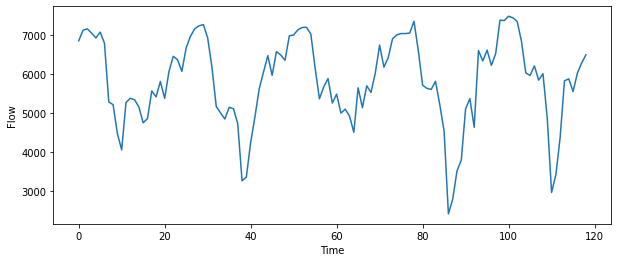

In [2]:
# Import Data
data = pd.read_csv("data.csv")
time = data.time[0:119]
flow = data.flow[0:119]

# Visualise
plt.figure(figsize=(10,4))
plt.plot(flow)
plt.xlabel("Time")
plt.ylabel("Flow")
plt.show()

## Check Stationarity

In [3]:
dftest = adfuller(flow, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -6.196500979049965
2. P-Value :  5.947669315210753e-08
3. Num Of Lags :  10
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 108
5. Critical Values :
	 1% :  -3.4924012594942333
	 5% :  -2.8886968193364835
	 10% :  -2.5812552709190673


The p-value is very small, so we can safely assume that the process is stationary.

## Autocovariance Sequence

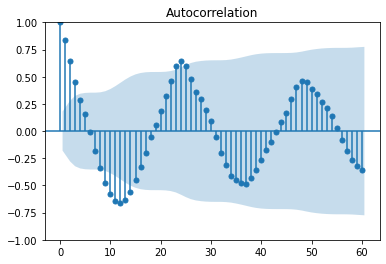

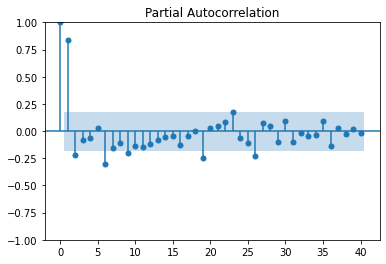

In [13]:
# Plot autocorrelation sequence
plot_acf(flow, lags=60)
plt.show()

# Plot partial autocorrelation sequence
plot_pacf(flow, lags=40, method='ywm')
plt.show()

Looking at the autocorrelation plot, we can pick 24 as the period of our model, as expected.

## Choose Parameters for Seasonal ARIMA Model

In [14]:
def optimize_SARIMA(parameters_list, s, data):
    """
    Input:
        parameters_list - list with (P, D, Q) tuples
        s - length of season
        data - the exogenous variable
    Output:
        Return a dataframe with parameters and their corresponding AIC and SSE.        
    """
    
    results = []
    
    for param in parameters_list:
        try: 
            model = SARIMAX(data, 
                            order=(0, 0, 0), 
                            seasonal_order=(param[0], param[1], param[2], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(P, D, Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [25]:
import warnings
warnings.filterwarnings("ignore")

P = range(0, 10, 1)
D = range(0, 1, 1)
Q = range(0, 1, 1)
s = 24

parameters_list = list(product(P,D,Q))

result_df = optimize_SARIMA(parameters_list, 24, flow)

# Ordered by AIC
result_df.head()

,"(P, D, Q)",AIC
0,"(4, 0, 0)",1968.935583
1,"(5, 0, 0)",1970.935582
2,"(2, 0, 0)",1971.009204
3,"(3, 0, 0)",1972.604225
4,"(6, 0, 0)",1974.265312


## Fit SARIMA Model

In [30]:
# Separate data into training and testing
index_train_data = 90
train_data = flow[: index_train_data]
test_data = flow[index_train_data :]

# define model
model = SARIMAX(train_data,
                order=(0,0,0),
                seasonal_order=(1,0,0,24))

#fit the model
model_fit = model.fit()
preds_df = (model_fit.get_prediction(start=index_train_data, end=119).summary_frame(alpha=0.05))

#summary of the model
print(model_fit.summary())

                                SARIMAX Results                                 
Dep. Variable:                     flow   No. Observations:                   90
Model:             SARIMAX(1, 0, 0, 24)   Log Likelihood                -773.422
Date:                  Tue, 27 Sep 2022   AIC                           1550.843
Time:                          00:22:59   BIC                           1555.843
Sample:                               0   HQIC                          1552.859
                                   - 90                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.9917      0.010    102.643      0.000       0.973       1.011
sigma2      5.692e+05   6.65e+04      8.557      0.000    4.39e+05       7e+05
Ljung-Box (L1) (Q):                 

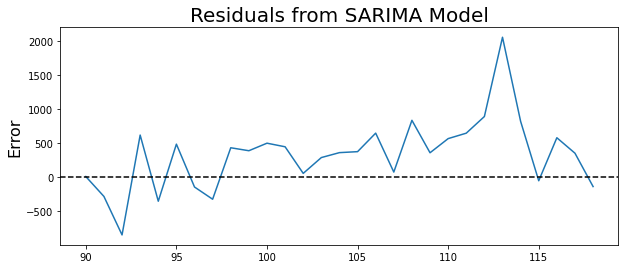

In [31]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.show()

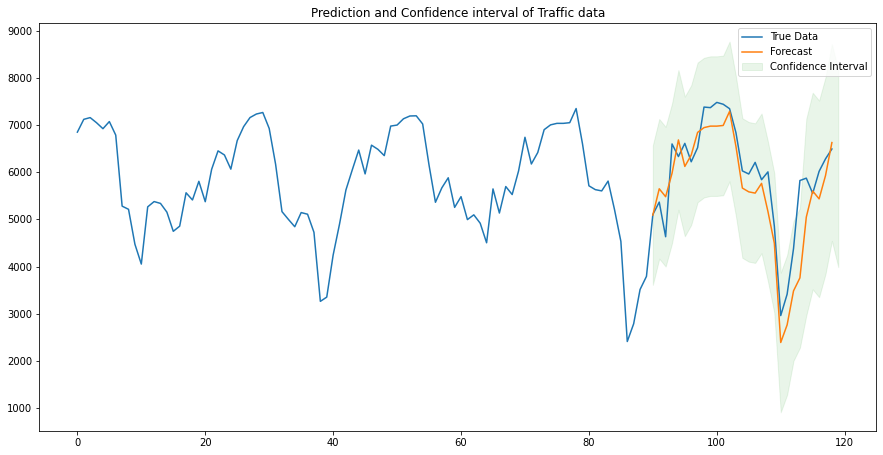

In [34]:
# Plot data and prediction
plt.figure(figsize=(15,7.5))
plt.plot(flow, label="True Data")
plt.plot(predictions, label="Forecast")
plt.fill_between(preds_df.index, 
                 preds_df['mean_ci_lower'], 
                 preds_df['mean_ci_upper'],
                 color='C2', 
                 alpha=0.1,
                 label="Confidence Interval")
plt.title("Prediction and Confidence interval of Traffic data")
plt.legend()
plt.show()